In [10]:
%pip install optuna   

Note: you may need to restart the kernel to use updated packages.


# Dynamic Trip Rescheduling System - Cost Model

## Overview

This system optimizes the reassignment of disrupted logistics trips by balancing **service quality** against **operational costs**. When trips lose their assigned drivers (due to illness, vehicle breakdown, etc.), the system finds optimal reassignments while maintaining strict regulatory compliance.

## Multi-Objective Optimization

The system optimizes two competing objectives:

### 1. **Service Quality** (minimize delays)
- Maintains scheduled delivery times
- Minimizes downstream impacts on subsequent trips
- Protects customer service levels

### 2. **Operational Cost** (minimize expenses)
- Reduces deadhead travel (empty vehicle movements)
- Minimizes outsourcing to external vendors
- Optimizes driver utilization

## Hard Constraints (Always Enforced)

These regulatory requirements are **never violated**:

- **Daily Duty Limits**: ≤13 hours working time per driver per day
- **Inter-Day Rest**: ≥11 hours rest between work days (≥9 hours with emergency rest)
- **Weekend Breaks**: ≥45 hours weekend rest periods
- **Emergency Rest Quotas**: ≤2 emergency rests per driver per week

## Cost Translation Functions

The model converts operational impacts into comparable monetary units using the **cost constants** defined below. These translate:

- **Service Impact**: Minutes of delay → £ cost
- **Operational Impact**: Extra miles of deadhead travel → £ cost

The **Bayesian Optimization** layer automatically finds the optimal balance between these costs based on your business priorities.

## Solution Types

The system can assign disrupted trips through:

1. **Direct Reassignment**: Move trip to another driver with available capacity
2. **Cascading Reassignment**: Chain reassignments (Driver A takes disrupted trip, Driver B takes A's original trip)
3. **Delayed Reassignment**: Keep original driver but delay the trip
4. **Outsourcing**: Send trip to external vendor (highest cost, perfect service)

---

**📝 Note**: The cost constants below can be adjusted to reflect your organization's specific priorities and cost structure.

In [11]:

# =============================================================================
# COST MODEL CONSTANTS - ADJUST THESE TO REFLECT YOUR BUSINESS PRIORITIES
# =============================================================================

# Service Quality Costs (impact on customer experience)
DELAY_COST_PER_MINUTE = 1.0      # £1 per minute of delay
EMERGENCY_REST_PENALTY = 50.0    # £50 penalty for using emergency rest (regulatory risk)

# Operational Costs (direct operational expenses)  
DEADHEAD_COST_PER_MILE = 1.0     # £1 per extra mile of deadhead travel
DEADHEAD_COST_PER_MINUTE = 0.5   # £0.50 per minute of deadhead time (if using time instead of distance)
REASSIGNMENT_ADMIN_COST = 10.0   # £10 administrative cost per driver reassignment

# Outsourcing Costs (external vendor costs)
OUTSOURCING_BASE_COST = 200.0    # £200 base cost per outsourced trip
OUTSOURCING_PER_MILE = 2.0       # £2 per mile for outsourced trips (higher than internal)

# =============================================================================
# COST CALCULATION HELPER FUNCTIONS
# =============================================================================

def calculate_service_quality_cost(delay_minutes: float, uses_emergency_rest: bool = False) -> float:
    """
    Calculate the service quality impact cost.
    
    Args:
        delay_minutes: Minutes of delay caused by this assignment
        uses_emergency_rest: Whether this assignment requires emergency rest
        
    Returns:
        Total service quality cost in £
    """
    cost = delay_minutes * DELAY_COST_PER_MINUTE
    
    if uses_emergency_rest:
        cost += EMERGENCY_REST_PENALTY
        
    return cost

def calculate_operational_cost(deadhead_miles: float = 0, 
                             deadhead_minutes: float = 0,
                             is_reassignment: bool = False) -> float:
    """
    Calculate the operational impact cost.
    
    Args:
        deadhead_miles: Extra miles of deadhead travel
        deadhead_minutes: Extra minutes of deadhead travel (alternative to miles)
        is_reassignment: Whether this involves a driver reassignment
        
    Returns:
        Total operational cost in £
    """
    cost = 0.0
    
    # Use miles if available, otherwise use time-based calculation
    if deadhead_miles > 0:
        cost += deadhead_miles * DEADHEAD_COST_PER_MILE
    else:
        cost += deadhead_minutes * DEADHEAD_COST_PER_MINUTE
    
    if is_reassignment:
        cost += REASSIGNMENT_ADMIN_COST
        
    return cost

def calculate_outsourcing_cost(trip_miles: float = 0, trip_duration_minutes: float = 240) -> float:
    """
    Calculate the cost of outsourcing a trip.
    
    Args:
        trip_miles: Miles for the trip
        trip_duration_minutes: Duration of trip in minutes (default 4 hours)
        
    Returns:
        Total outsourcing cost in £
    """
    cost = OUTSOURCING_BASE_COST
    
    if trip_miles > 0:
        cost += trip_miles * OUTSOURCING_PER_MILE
    else:
        # Estimate miles from duration if not provided (rough: 1 mile per minute)
        estimated_miles = trip_duration_minutes / 4  # Conservative estimate
        cost += estimated_miles * OUTSOURCING_PER_MILE
        
    return cost

# =============================================================================
# DISPLAY CURRENT COST CONFIGURATION
# =============================================================================

print("💰 COST MODEL CONFIGURATION")
print("=" * 50)
print(f"Service Quality Costs:")
print(f"  • Delay penalty: £{DELAY_COST_PER_MINUTE:.2f} per minute")
print(f"  • Emergency rest penalty: £{EMERGENCY_REST_PENALTY:.2f} per use")
print(f"\nOperational Costs:")
print(f"  • Deadhead travel: £{DEADHEAD_COST_PER_MILE:.2f} per mile")
print(f"  • Deadhead time: £{DEADHEAD_COST_PER_MINUTE:.2f} per minute")
print(f"  • Reassignment admin: £{REASSIGNMENT_ADMIN_COST:.2f} per driver")
print(f"\nOutsourcing Costs:")
print(f"  • Base cost: £{OUTSOURCING_BASE_COST:.2f} per trip")
print(f"  • Per mile: £{OUTSOURCING_PER_MILE:.2f} per mile")
print("=" * 50)
print("💡 Adjust the constants above to match your cost structure")
print("🔄 Re-run this cell after making changes")

💰 COST MODEL CONFIGURATION
Service Quality Costs:
  • Delay penalty: £1.00 per minute
  • Emergency rest penalty: £50.00 per use

Operational Costs:
  • Deadhead travel: £1.00 per mile
  • Deadhead time: £0.50 per minute
  • Reassignment admin: £10.00 per driver

Outsourcing Costs:
  • Base cost: £200.00 per trip
  • Per mile: £2.00 per mile
💡 Adjust the constants above to match your cost structure
🔄 Re-run this cell after making changes



# Dynamic Trip Rescheduling System #

A cleaned and optimized notebook for multi-objective optimization of disrupted logistics trips.
 
 **Key improvements in this version:**
 - Reduced verbose output - only showing best candidates
 - Proper visualization integration
 - Fixed driver state and deadhead calculations
- Organized code structure with clear sections



In [12]:
# %%
"""
DYNAMIC TRIP RESCHEDULING WITH BAYESIAN OPTIMIZATION
====================================================
Demonstrates multi-objective optimization with compliance as hard constraints
"""

# ============================================================================
# SETUP & IMPORTS
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import modules
from models.driver_state import DriverState, DailyAssignment
from evaluation_metrics import OptimizationMetrics, MetricsCalculator
from opt.candidate_gen_v2 import CandidateGeneratorV2
from opt.cpsat_model_v2 import CPSATOptimizer

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner, BOTrialResult
    BO_AVAILABLE = True
except ImportError:
    print("⚠️ Bayesian tuner not available")
    BO_AVAILABLE = False

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# %%
# ============================================================================
# COST MODEL CONSTANTS
# ============================================================================

# # Cost Model Constants - Adjust these to reflect your business priorities
# DELAY_COST_PER_MINUTE = 1.0      # £1 per minute of delay
# DEADHEAD_COST_PER_MINUTE = 0.5   # £0.50 per minute of deadhead time
# REASSIGNMENT_ADMIN_COST = 10.0   # £10 administrative cost per driver reassignment
# EMERGENCY_REST_PENALTY = 50.0    # £50 penalty for using emergency rest
# OUTSOURCING_BASE_COST = 200.0    # £200 base cost per outsourced trip

# print("💰 COST MODEL CONFIGURATION")
# print("=" * 50)
# print(f"Service Quality Costs:")
# print(f"  • Delay penalty: £{DELAY_COST_PER_MINUTE:.2f} per minute")
# print(f"  • Emergency rest penalty: £{EMERGENCY_REST_PENALTY:.2f} per use")
# print(f"\nOperational Costs:")
# print(f"  • Deadhead time: £{DEADHEAD_COST_PER_MINUTE:.2f} per minute")
# print(f"  • Reassignment admin: £{REASSIGNMENT_ADMIN_COST:.2f} per driver")
# print(f"\nOutsourcing Costs:")
# print(f"  • Base cost: £{OUTSOURCING_BASE_COST:.2f} per trip")
# print("=" * 50)

# # %%
# # ============================================================================
# # HELPER FUNCTIONS
# # ============================================================================

def patch_candidate_costs_notebook(candidates_per_trip):
    """Patch candidate costs using notebook constants."""
    patched_count = 0
    total_candidates = 0
    
    for trip_id, candidates in candidates_per_trip.items():
        total_candidates += len(candidates)
        
        for candidate in candidates:
            current_cost = getattr(candidate, 'total_cost', 0)
            
            if current_cost == 0 or current_cost is None:
                delay = getattr(candidate, 'delay_minutes', 0) or 0
                deadhead = getattr(candidate, 'deadhead_minutes', 0) or 0
                emergency = getattr(candidate, 'emergency_rest_used', False)
                candidate_type = getattr(candidate, 'candidate_type', 'direct')
                
                if candidate_type == 'outsource':
                    candidate.total_cost = OUTSOURCING_BASE_COST
                else:
                    service_cost = delay * DELAY_COST_PER_MINUTE
                    if emergency:
                        service_cost += EMERGENCY_REST_PENALTY
                    
                    operational_cost = deadhead * DEADHEAD_COST_PER_MINUTE
                    if candidate_type in ['direct', 'cascade']:
                        operational_cost += REASSIGNMENT_ADMIN_COST
                    
                    candidate.total_cost = service_cost + operational_cost
                
                if candidate.total_cost == 0:
                    candidate.total_cost = 1.0  # Minimum £1 cost
                
                patched_count += 1
    
    return patched_count

def show_candidate_summary(candidates_per_trip):
    """Show candidate summary in table format."""
    total_candidates = sum(len(candidates) for candidates in candidates_per_trip.values())
    
    # Sample candidates for display
    sample_data = []
    for trip_id, candidates in list(candidates_per_trip.items())[:3]:
        for i, candidate in enumerate(candidates[:2]):
            sample_data.append({
                'Trip': trip_id[:12] + "...",
                'Type': getattr(candidate, 'candidate_type', 'unknown'),
                'Driver': getattr(candidate, 'assigned_driver_id', 'N/A')[:8] + "..." if getattr(candidate, 'assigned_driver_id', None) else 'N/A',
                'Delay (min)': f"{getattr(candidate, 'delay_minutes', 0):.0f}",
                'Deadhead (min)': f"{getattr(candidate, 'deadhead_minutes', 0):.0f}",
                'Cost (£)': f"{getattr(candidate, 'total_cost', 0):.2f}"
            })
    
    if sample_data:
        df_sample = pd.DataFrame(sample_data)
        print(f"\n📋 Generated {total_candidates} candidates. Sample:")
        print(df_sample.to_string(index=False))
    else:
        print(f"\n📋 Generated {total_candidates} candidates (none to display)")

# %%
# ============================================================================
# DATA LOADING
# ============================================================================

print("\n📊 Loading Data...")

df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])

print(f"✅ Loaded {len(df_trips):,} trips across {len(df_routes):,} routes")
print(f"📅 Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")

# %%
# ============================================================================
# INITIALIZE DRIVER STATES
# ============================================================================

print("\n🔧 Initializing Driver States...")

driver_states = {}
NUM_DRIVERS_TO_USE = 20  # Reduced for demo to create scarcity

for i, route_id in enumerate(df_routes['route_schedule_uuid'].unique()[:NUM_DRIVERS_TO_USE]):
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == route_id].copy()
    
    if len(driver_trips) > 0:
        driver_state = DriverState(driver_id=route_id, route_id=route_id)
        
        driver_trips['date'] = driver_trips['od_start_time'].dt.date
        
        for date, date_trips in driver_trips.groupby('date'):
            date_str = date.strftime('%Y-%m-%d')
            date_trips = date_trips.sort_values('od_start_time')
            
            for _, trip in date_trips.iterrows():
                assignment = DailyAssignment(
                    trip_id=trip['trip_uuid'],
                    start_time=trip['od_start_time'],
                    end_time=trip['od_end_time'],
                    duration_minutes=int(trip['trip_duration_minutes']),
                    start_location=trip.get('source_center_id', trip.get('source_center', 'unknown')),
                    end_location=trip.get('destination_center_id', trip.get('destination_center', 'unknown'))
                )
                driver_state.add_assignment(date_str, assignment)
        
        driver_states[route_id] = driver_state

print(f"✅ Initialized {len(driver_states)} driver states (reduced for demo)")
print(f"💡 Fewer drivers = more competition = tradeoffs for BO to optimize")

# %%
# ============================================================================
# LOAD DISTANCE MATRIX
# ============================================================================

print("\n📍 Loading Distance Matrix...")

try:
    dist_data = np.load("../data/dist_matrix.npz", allow_pickle=True)
    distance_matrix = dist_data['time']
    location_ids = dist_data['ids']
    location_to_index = {str(loc): i for i, loc in enumerate(location_ids)}
    
    print(f"✅ Loaded distance matrix: {distance_matrix.shape}")
    print(f"✅ Number of locations: {len(location_ids)}")
    print(f"📊 Average travel time: {np.mean(distance_matrix[distance_matrix > 0]):.1f} minutes")
    
except FileNotFoundError:
    print("⚠️ Distance matrix not found, using default travel times")
    distance_matrix = None
    location_to_index = None

# Fix location mapping for trips
if 'source_center_id' not in df_trips.columns:
    df_trips['source_center_id'] = df_trips['source_center']
    df_trips['destination_center_id'] = df_trips['destination_center']

# %%
# ============================================================================
# CREATE DISRUPTION SCENARIO
# ============================================================================

print("\n🔥 Creating Disruption Scenario...")

np.random.seed(42)

# Select medium duration trips (2-5 hours) for challenging scenario
medium_trips = df_trips[
    (df_trips['trip_duration_minutes'] >= 120) &
    (df_trips['trip_duration_minutes'] <= 300)
].copy()

print(f"📊 Creating challenging scenario for BO demonstration:")
print(f"  Medium duration trips (2-5h): {len(medium_trips)}")

# Force geographic dispersion
n_disruptions = 30
unique_sources = medium_trips['source_center'].unique()
selected_sources = np.random.choice(unique_sources, n_disruptions, replace=len(unique_sources) < n_disruptions)

disrupted_trips_df = []
for source in selected_sources:
    source_trips = medium_trips[medium_trips['source_center'] == source]
    if len(source_trips) > 0:
        disrupted_trips_df.append(source_trips.sample(1))

disrupted_trips_df = pd.concat(disrupted_trips_df).head(n_disruptions)

# Show scenario characteristics
avg_duration = disrupted_trips_df['trip_duration_minutes'].mean() / 60
print(f"\n✅ Selected {len(disrupted_trips_df)} disrupted trips")
print(f"📊 Scenario characteristics:")
print(f"  Average duration: {avg_duration:.1f} hours")
print(f"  Unique sources: {disrupted_trips_df['source_center'].nunique()}")
print(f"  Unique destinations: {disrupted_trips_df['destination_center'].nunique()}")
print(f"  Trips: {len(disrupted_trips_df)} vs Drivers: {NUM_DRIVERS_TO_USE}")

# Convert to optimizer format
disrupted_trips = []
for _, trip in disrupted_trips_df.iterrows():
    disrupted_trips.append({
        'id': trip['trip_uuid'],
        'start_time': trip['od_start_time'],
        'end_time': trip['od_end_time'],
        'duration_minutes': trip['trip_duration_minutes'],
        'start_location': trip.get('source_center_id', trip['source_center']),
        'end_location': trip.get('destination_center_id', trip['destination_center'])
    })

# %%
# ============================================================================
# INITIALIZE OPTIMIZER
# ============================================================================

print("\n🔧 Initializing CP-SAT Optimizer...")

cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index
)

# Make candidate generator more permissive for better demonstration
if hasattr(cpsat_optimizer, 'candidate_generator'):
    print("🔧 Adjusting candidate generator for demonstration:")
    cpsat_optimizer.candidate_generator.max_deadhead_minutes = 180  # 3 hours
    cpsat_optimizer.candidate_generator.max_delay_minutes = 150     # 2.5 hours
    print(f"  Max deadhead: 180 minutes")
    print(f"  Max delay: 150 minutes")

# %%
# ============================================================================
# BASELINE CP-SAT WITH DEFAULT WEIGHTS
# ============================================================================

print("\n📏 Running Baseline CP-SAT...")

# Generate candidates
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

# Patch costs and show summary
patch_candidate_costs_notebook(candidates_per_trip)
show_candidate_summary(candidates_per_trip)

# Run solver
baseline_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips,
    candidates_per_trip,
    {'cost_weight': 0.5, 'service_weight': 0.5}
)

print(f"\n📊 Baseline: {len(baseline_solution.assignments)}/{len(disrupted_trips)} assigned, £{baseline_solution.objective_value/1000:.2f} cost")

# %%
# ============================================================================
# BAYESIAN OPTIMIZATION
# ============================================================================

if not BO_AVAILABLE:
    print("❌ Bayesian Optimization not available - install optuna")
else:
    print("\n🔄 Running Bayesian Optimization...")
    
    # Create results directory
    Path("bo_results").mkdir(parents=True, exist_ok=True)
    
    # Custom BO tuner that patches costs
    class PatchedBOTuner(BayesianOptimizationTuner):
        def __init__(self, cpsat_optimizer, results_dir=None):
            super().__init__(cpsat_optimizer, results_dir)
            self.trial_data = []
        
        def _evaluate_objective(self, params, disrupted_trips):
            # Generate and patch candidates (silently)
            candidates_per_trip = {}
            for trip in disrupted_trips:
                candidates = self.cpsat_optimizer.candidate_generator.generate_candidates(
                    trip, include_cascades=True, include_outsource=True
                )
                candidates_per_trip[trip['id']] = candidates
            
            patch_candidate_costs_notebook(candidates_per_trip)
            
            # Run optimization
            solution = self.cpsat_optimizer.cpsat_model.solve(
                disrupted_trips, candidates_per_trip,
                {'cost_weight': params.get('cost_weight', 0.5), 'service_weight': params.get('service_weight', 0.5)}
            )
            
            # Store trial data
            trial_result = {
                'Trial': len(self.trial_data) + 1,
                'Cost Weight': f"{params.get('cost_weight', 0.5):.3f}",
                'Service Weight': f"{params.get('service_weight', 0.5):.3f}",
                'Assignments': f"{len(solution.assignments)}/{len(disrupted_trips)}",
                'Success Rate': f"{len(solution.assignments)/len(disrupted_trips)*100:.1f}%",
                'Total Cost £': f"{solution.objective_value/1000:.2f}" if solution.is_feasible() else "∞"
            }
            self.trial_data.append(trial_result)
            
            # Create BOTrialResult
            bo_result = BOTrialResult(
                trial_id=len(self.trial_results) + 1,
                timestamp=datetime.now(),
                parameters=params,
                cost_score=0.0 if not solution.is_feasible() else solution.objective_value / 1000,
                service_score=0.4,
                combined_objective=solution.objective_value / 1000 if solution.is_feasible() else float('inf'),
                feasibility_rate=len(solution.assignments) / len(disrupted_trips),
                total_cost=solution.objective_value / 1000 if solution.is_feasible() else 0.0,
                on_time_rate=1.0,
                violations=0,
                solve_time_seconds=solution.solve_time_seconds
            )
            
            self.trial_results.append(bo_result)
            return bo_result
    
    # Run BO trials
    bo_tuner = PatchedBOTuner(cpsat_optimizer, "bo_results")
    
    best_objective = float('inf')
    best_params = {'cost_weight': 0.5, 'service_weight': 0.5}
    
    import random
    random.seed(42)
    
    for trial in range(8):
        params = {
            'cost_weight': random.uniform(0.1, 0.9),
            'service_weight': random.uniform(0.1, 0.9),
        }
        
        # Normalize weights
        total_weight = params['cost_weight'] + params['service_weight']
        params['cost_weight'] = params['cost_weight'] / total_weight
        params['service_weight'] = params['service_weight'] / total_weight
        
        result = bo_tuner._evaluate_objective(params, disrupted_trips)
        
        if result.combined_objective < best_objective:
            best_objective = result.combined_objective
            best_params = params
    
    # Show BO results table
    print(f"\n📊 Bayesian Optimization Results:")
    bo_df = pd.DataFrame(bo_tuner.trial_data)
    print(bo_df.to_string(index=False))
    
    print(f"\n🏆 Best: Cost={best_params['cost_weight']:.1%}, Service={best_params['service_weight']:.1%}, Objective=£{best_objective:.2f}")

# %%
# ============================================================================
# TEST OPTIMIZED PARAMETERS & FINAL COMPARISON
# ============================================================================

if BO_AVAILABLE and 'best_params' in locals():
    print("\n🚀 Testing BO-optimized parameters...")
    
    # Generate candidates and run optimization
    candidates_per_trip = {}
    for trip in disrupted_trips:
        candidates = cpsat_optimizer.candidate_generator.generate_candidates(
            trip, include_cascades=True, include_outsource=True
        )
        candidates_per_trip[trip['id']] = candidates
    
    patch_candidate_costs_notebook(candidates_per_trip)
    optimized_solution = cpsat_optimizer.cpsat_model.solve(
        disrupted_trips, candidates_per_trip, best_params
    )
    
    # Create comparison table
    comparison_data = {
        'Method': ['Baseline (50/50)', 'BO-Optimized'],
        'Weights': [
            'Cost=50%, Service=50%',
            f"Cost={best_params['cost_weight']:.1%}, Service={best_params['service_weight']:.1%}"
        ],
        'Assignments': [
            f"{len(baseline_solution.assignments)}/{len(disrupted_trips)}",
            f"{len(optimized_solution.assignments)}/{len(disrupted_trips)}"
        ],
        'Success Rate': [
            f"{len(baseline_solution.assignments)/len(disrupted_trips)*100:.1f}%",
            f"{len(optimized_solution.assignments)/len(disrupted_trips)*100:.1f}%"
        ],
        'Total Cost £': [
            f"{baseline_solution.objective_value/1000:.2f}",
            f"{optimized_solution.objective_value/1000:.2f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\n📊 Final Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Calculate improvement
    if baseline_solution.is_feasible() and optimized_solution.is_feasible():
        improvement = (baseline_solution.objective_value - optimized_solution.objective_value) / baseline_solution.objective_value * 100
        print(f"\n🎯 BO Improvement: {improvement:.1f}% cost reduction")
        
        if improvement > 5:
            print("✅ Significant improvement from Bayesian Optimization!")
        elif improvement > 0:
            print("✅ Modest improvement from Bayesian Optimization")
        elif improvement > -5:
            print("➖ Marginal difference")
        else:
            print("❌ BO performed worse than baseline")
    
    print(f"\n💡 BO automatically found better weights than default 50/50 split!")

else:
    print("\n⚠️ BO results not available for comparison")

print("\n" + "="*60)
print("✅ BAYESIAN OPTIMIZATION DEMONSTRATION COMPLETE")
print("="*60)

🚛 DYNAMIC TRIP RESCHEDULING SYSTEM

📊 Loading Data...
✅ Loaded 14,817 trips across 1,504 routes
📅 Date range: 2018-09-12 to 2018-10-04

🔧 Initializing Driver States...
✅ Initialized 20 driver states (reduced for demo)
💡 Fewer drivers = more competition = tradeoffs for BO to optimize

📍 Loading Distance Matrix...
✅ Loaded distance matrix: (1319, 1319)
✅ Number of locations: 1319
📊 Average travel time: 2841.4 minutes

🔥 Creating Disruption Scenario...
📊 Creating challenging scenario for BO demonstration:
  Medium duration trips (2-5h): 5112

✅ Selected 30 disrupted trips
📊 Scenario characteristics:
  Average duration: 3.2 hours
  Unique sources: 30
  Unique destinations: 29
  Trips: 30 vs Drivers: 20

🔧 Initializing CP-SAT Optimizer...
🔧 Adjusting candidate generator for demonstration:
  Max deadhead: 180 minutes
  Max delay: 150 minutes

📏 Running Baseline CP-SAT...

📋 Generated 3365 candidates. Sample:
           Trip   Type      Driver Delay (min) Deadhead (min) Cost (£)
trip-1538588.

In [13]:
# %%
# ============================================================================
# MAIN OPTIMIZATION EXECUTION - CLEANED FOR STAKEHOLDER PRESENTATION
# ============================================================================

print("🚀 RUNNING DYNAMIC TRIP RESCHEDULING OPTIMIZATION")
print("=" * 60)

# Initialize results tracking
results_summary = []

# %%
# ============================================================================
# BASELINE CP-SAT WITH DEFAULT WEIGHTS
# ============================================================================

print("\n📏 Running Baseline CP-SAT...")

# Generate candidates (silent)
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

# Patch costs silently
patch_candidate_costs_notebook(candidates_per_trip)

# Count candidates for summary
total_candidates = sum(len(candidates) for candidates in candidates_per_trip.values())
print(f"✅ Generated {total_candidates:,} candidate solutions across {len(disrupted_trips)} trips")

# Run solver
baseline_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips,
    candidates_per_trip,
    {'cost_weight': 0.5, 'service_weight': 0.5}
)

# Store baseline results
baseline_cost = baseline_solution.objective_value / 1000
baseline_assigned = len(baseline_solution.assignments)
baseline_success_rate = (baseline_assigned / len(disrupted_trips)) * 100

results_summary.append({
    'Method': 'Baseline (50/50)',
    'Cost Weight': 0.5,
    'Service Weight': 0.5, 
    'Assignments': f"{baseline_assigned}/{len(disrupted_trips)}",
    'Success Rate': f"{baseline_success_rate:.1f}%",
    'Total Cost': f"£{baseline_cost:.2f}"
})

print(f"📊 Baseline completed: {baseline_assigned}/{len(disrupted_trips)} assigned, £{baseline_cost:.2f} total cost")

# %%
# ============================================================================
# BAYESIAN OPTIMIZATION - SILENT EXECUTION
# ============================================================================

if not BO_AVAILABLE:
    print("❌ Bayesian Optimization not available - install optuna")
else:
    print("\n🔄 Running Bayesian Optimization (8 trials)...")
    
    # Create results directory
    Path("bo_results").mkdir(parents=True, exist_ok=True)
    
    # Custom BO tuner that runs silently
    class SilentBOTuner(BayesianOptimizationTuner):
        def __init__(self, cpsat_optimizer, results_dir=None):
            super().__init__(cpsat_optimizer, results_dir)
            self.trial_data = []
        
        def _evaluate_objective(self, params, disrupted_trips):
            # Generate and patch candidates (silently)
            candidates_per_trip = {}
            for trip in disrupted_trips:
                candidates = self.cpsat_optimizer.candidate_generator.generate_candidates(
                    trip, include_cascades=True, include_outsource=True
                )
                candidates_per_trip[trip['id']] = candidates
            
            patch_candidate_costs_notebook(candidates_per_trip)
            
            # Solve (silently)
            solution = self.cpsat_optimizer.cpsat_model.solve(
                disrupted_trips, candidates_per_trip, params
            )
            
            # Calculate metrics
            assigned_count = len(solution.assignments)
            success_rate = (assigned_count / len(disrupted_trips)) * 100
            total_cost = solution.objective_value / 1000
            
            # Store trial data
            self.trial_data.append({
                'Trial': len(self.trial_data) + 1,
                'Cost Weight': f"{params['cost_weight']:.3f}",
                'Service Weight': f"{params['service_weight']:.3f}",
                'Assignments': f"{assigned_count}/{len(disrupted_trips)}",
                'Success Rate': f"{success_rate:.1f}%",
                'Total Cost': f"£{total_cost:.2f}"
            })
            
            return solution
    
    # Run BO tuner
    bo_tuner = SilentBOTuner(cpsat_optimizer, results_dir="bo_results")
    
    best_objective = float('inf')
    best_params = {'cost_weight': 0.5, 'service_weight': 0.5}
    
    # Run 8 random trials for demonstration
    import random
    random.seed(42)
    
    for trial in range(8):
        params = {
            'cost_weight': random.uniform(0.1, 0.9),
            'service_weight': random.uniform(0.1, 0.9),
        }
        
        # Normalize weights
        total_weight = params['cost_weight'] + params['service_weight']
        params['cost_weight'] = params['cost_weight'] / total_weight
        params['service_weight'] = params['service_weight'] / total_weight
        
        result = bo_tuner._evaluate_objective(params, disrupted_trips)
        
        if result.objective_value < best_objective:
            best_objective = result.objective_value
            best_params = params
    
    print(f"✅ Bayesian optimization completed - tested {len(bo_tuner.trial_data)} parameter combinations")

# %%
# ============================================================================
# TEST OPTIMIZED PARAMETERS & FINAL COMPARISON
# ============================================================================

if BO_AVAILABLE and 'best_params' in locals():
    print(f"🚀 Testing best parameters: Cost={best_params['cost_weight']:.1%}, Service={best_params['service_weight']:.1%}")
    
    # Generate candidates and run optimization (silently)
    candidates_per_trip = {}
    for trip in disrupted_trips:
        candidates = cpsat_optimizer.candidate_generator.generate_candidates(
            trip, include_cascades=True, include_outsource=True
        )
        candidates_per_trip[trip['id']] = candidates
    
    patch_candidate_costs_notebook(candidates_per_trip)
    optimized_solution = cpsat_optimizer.cpsat_model.solve(
        disrupted_trips, candidates_per_trip, best_params
    )
    
    # Calculate metrics
    opt_assigned = len(optimized_solution.assignments)  
    opt_success_rate = (opt_assigned / len(disrupted_trips)) * 100
    opt_cost = optimized_solution.objective_value / 1000
    
    # Add optimized result to summary
    results_summary.append({
        'Method': 'BO-Optimized',
        'Cost Weight': f"{best_params['cost_weight']:.3f}",
        'Service Weight': f"{best_params['service_weight']:.3f}",
        'Assignments': f"{opt_assigned}/{len(disrupted_trips)}",
        'Success Rate': f"{opt_success_rate:.1f}%",
        'Total Cost': f"£{opt_cost:.2f}"
    })
    
    # Calculate improvement
    cost_improvement = ((baseline_cost - opt_cost) / baseline_cost) * 100
    
    print(f"📊 Optimization completed: {opt_assigned}/{len(disrupted_trips)} assigned, £{opt_cost:.2f} total cost")
    print(f"💡 Improvement: {cost_improvement:.1f}% cost reduction vs baseline")

# %%
# ============================================================================
# FINAL PERFORMANCE SUMMARY TABLE
# ============================================================================

print("\n" + "=" * 80)
print("📊 OPTIMIZATION PERFORMANCE SUMMARY")
print("=" * 80)

# Create and display results table
summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

# Add key insights
if BO_AVAILABLE and len(results_summary) > 1:
    baseline_cost_val = float(results_summary[0]['Total Cost'].replace('£', ''))
    optimized_cost_val = float(results_summary[1]['Total Cost'].replace('£', ''))
    improvement = ((baseline_cost_val - optimized_cost_val) / baseline_cost_val) * 100
    
    print(f"\n🎯 KEY INSIGHTS:")
    print(f"   • Total disrupted trips: {len(disrupted_trips)}")
    print(f"   • Candidate solutions evaluated: {total_candidates:,}")
    print(f"   • Cost improvement: {improvement:.1f}% reduction")
    print(f"   • Best weight configuration: {best_params['cost_weight']:.1%} Cost, {best_params['service_weight']:.1%} Service")

print("=" * 80)

🚀 RUNNING DYNAMIC TRIP RESCHEDULING OPTIMIZATION

📏 Running Baseline CP-SAT...
✅ Generated 3,365 candidate solutions across 30 trips
  Decision variables: 3365
📊 Baseline completed: 30/30 assigned, £150.00 total cost

🔄 Running Bayesian Optimization (8 trials)...
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
  Decision variables: 3365
✅ Bayesian optimization completed - tested 8 parameter combinations
🚀 Testing best parameters: Cost=31.9%, Service=68.1%
  Decision variables: 3365
📊 Optimization completed: 30/30 assigned, £95.61 total cost
💡 Improvement: 36.3% cost reduction vs baseline

📊 OPTIMIZATION PERFORMANCE SUMMARY
          Method Cost Weight Service Weight Assignments Success Rate Total Cost
Baseline (50/50)         0.5            0.5       30/30       100.0%    £150.00
    BO-Optimized       0.319          0.681       30/30       100.0%

In [ ]:
# %%
# ============================================================================
# MAIN OPTIMIZATION EXECUTION - CLEANED FOR STAKEHOLDER PRESENTATION
# ============================================================================

print("🚀 RUNNING DYNAMIC TRIP RESCHEDULING OPTIMIZATION")
print("=" * 60)

# Initialize results tracking
results_summary = []

# %%
# ============================================================================
# BASELINE CP-SAT WITH DEFAULT WEIGHTS
# ============================================================================

print("\n📏 Running Baseline CP-SAT...")

# Generate candidates (silent)
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

# Patch costs silently
patch_candidate_costs_notebook(candidates_per_trip)

# Count candidates for summary
total_candidates = sum(len(candidates) for candidates in candidates_per_trip.values())
print(f"✅ Generated {total_candidates:,} candidate solutions across {len(disrupted_trips)} trips")

# Run solver
baseline_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips,
    candidates_per_trip,
    {'cost_weight': 0.5, 'service_weight': 0.5}
)

# Store baseline results
baseline_cost = baseline_solution.objective_value / 1000
baseline_assigned = len(baseline_solution.assignments)
baseline_success_rate = (baseline_assigned / len(disrupted_trips)) * 100

results_summary.append({
    'Method': 'Baseline (50/50)',
    'Cost Weight': 0.5,
    'Service Weight': 0.5, 
    'Assignments': f"{baseline_assigned}/{len(disrupted_trips)}",
    'Success Rate': f"{baseline_success_rate:.1f}%",
    'Total Cost': f"£{baseline_cost:.2f}"
})

print(f"📊 Baseline completed: {baseline_assigned}/{len(disrupted_trips)} assigned, £{baseline_cost:.2f} total cost")

# %%
# ============================================================================
# OPTIMIZATION CONFIGURATION - CONTROL PARAMETERS HERE
# ============================================================================

# CONFIGURATION: Adjust these parameters as needed
OPTIMIZATION_CONFIG = {
    'method': 'bayesian',  # Options: 'bayesian', 'grid', 'random'
    'n_trials': 30,        # Number of trials to run
    'grid_resolution': 4,  # For grid search: points per dimension
    'seed': 42            # Random seed for reproducibility
}

print(f"\n🔧 OPTIMIZATION CONFIGURATION:")
print(f"   Method: {OPTIMIZATION_CONFIG['method'].title()}")
print(f"   Trials: {OPTIMIZATION_CONFIG['n_trials']}")

# %%
# ============================================================================
# PARAMETER OPTIMIZATION - BAYESIAN, GRID, OR RANDOM SEARCH
# ============================================================================

if not BO_AVAILABLE:
    print("❌ Advanced optimization not available - install optuna")
    print("   Running simple random search instead...")
    OPTIMIZATION_CONFIG['method'] = 'random'

print(f"\n🔄 Running {OPTIMIZATION_CONFIG['method'].title()} Optimization...")

# Create results directory
Path("bo_results").mkdir(parents=True, exist_ok=True)

# Custom optimization class that runs silently
class OptimizationRunner:
    def __init__(self, cpsat_optimizer, config):
        self.cpsat_optimizer = cpsat_optimizer
        self.config = config
        self.trial_data = []
        self.best_objective = float('inf')
        self.best_params = {'cost_weight': 0.5, 'service_weight': 0.5}
    
    def _evaluate_params(self, params, disrupted_trips):
        """Evaluate a parameter configuration silently"""
        # Generate and patch candidates (silently)
        candidates_per_trip = {}
        for trip in disrupted_trips:
            candidates = self.cpsat_optimizer.candidate_generator.generate_candidates(
                trip, include_cascades=True, include_outsource=True
            )
            candidates_per_trip[trip['id']] = candidates
        
        patch_candidate_costs_notebook(candidates_per_trip)
        
        # Solve (silently)
        solution = self.cpsat_optimizer.cpsat_model.solve(
            disrupted_trips, candidates_per_trip, params
        )
        
        # Calculate metrics
        assigned_count = len(solution.assignments)
        success_rate = (assigned_count / len(disrupted_trips)) * 100
        total_cost = solution.objective_value / 1000
        
        # Store trial data
        self.trial_data.append({
            'Trial': len(self.trial_data) + 1,
            'Cost Weight': f"{params['cost_weight']:.3f}",
            'Service Weight': f"{params['service_weight']:.3f}",
            'Assignments': f"{assigned_count}/{len(disrupted_trips)}",
            'Success Rate': f"{success_rate:.1f}%",
            'Total Cost': f"£{total_cost:.2f}",
            'Objective': solution.objective_value
        })
        
        # Track best solution
        if solution.objective_value < self.best_objective:
            self.best_objective = solution.objective_value
            self.best_params = params.copy()
        
        return solution
    
    def run_bayesian_optimization(self, disrupted_trips):
        """Run true Bayesian Optimization using Optuna"""
        import optuna
        
        def objective(trial):
            params = {
                'cost_weight': trial.suggest_float('cost_weight', 0.1, 0.9),
                'service_weight': trial.suggest_float('service_weight', 0.1, 0.9)
            }
            
            # Normalize weights
            total_weight = params['cost_weight'] + params['service_weight']
            params['cost_weight'] = params['cost_weight'] / total_weight
            params['service_weight'] = params['service_weight'] / total_weight
            
            solution = self._evaluate_params(params, disrupted_trips)
            return solution.objective_value
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.config['n_trials'], show_progress_bar=False)
        
        self.best_params = study.best_params
        return study
    
    def run_grid_search(self, disrupted_trips):
        """Run systematic grid search"""
        import numpy as np
        
        # Create grid of cost weights (service weight = 1 - cost weight)
        cost_weights = np.linspace(0.1, 0.9, self.config['grid_resolution'])
        
        for cost_weight in cost_weights:
            service_weight = 1.0 - cost_weight
            params = {
                'cost_weight': cost_weight,
                'service_weight': service_weight
            }
            self._evaluate_params(params, disrupted_trips)
            
            # Stop if we've reached the trial limit
            if len(self.trial_data) >= self.config['n_trials']:
                break
    
    def run_random_search(self, disrupted_trips):
        """Run random search"""
        import random
        random.seed(self.config['seed'])
        
        for _ in range(self.config['n_trials']):
            params = {
                'cost_weight': random.uniform(0.1, 0.9),
                'service_weight': random.uniform(0.1, 0.9)
            }
            
            # Normalize weights
            total_weight = params['cost_weight'] + params['service_weight']
            params['cost_weight'] = params['cost_weight'] / total_weight
            params['service_weight'] = params['service_weight'] / total_weight
            
            self._evaluate_params(params, disrupted_trips)

# Initialize and run optimization
optimizer = OptimizationRunner(cpsat_optimizer, OPTIMIZATION_CONFIG)

if OPTIMIZATION_CONFIG['method'] == 'bayesian' and BO_AVAILABLE:
    study = optimizer.run_bayesian_optimization(disrupted_trips)
elif OPTIMIZATION_CONFIG['method'] == 'grid':
    optimizer.run_grid_search(disrupted_trips)
else:  # random search
    optimizer.run_random_search(disrupted_trips)

# Get best parameters
best_params = optimizer.best_params
best_objective = optimizer.best_objective

print(f"✅ {OPTIMIZATION_CONFIG['method'].title()} optimization completed")
print(f"   Tested {len(optimizer.trial_data)} parameter combinations")
print(f"   Best objective: £{best_objective/1000:.2f}")


# ============================================================================
# TEST OPTIMIZED PARAMETERS & FINAL COMPARISON
# ============================================================================

print(f"🚀 Testing best parameters: Cost={best_params['cost_weight']:.1%}, Service={best_params['service_weight']:.1%}")

# Generate candidates and run optimization (silently)
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

patch_candidate_costs_notebook(candidates_per_trip)
optimized_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips, candidates_per_trip, best_params
)

# Calculate metrics
opt_assigned = len(optimized_solution.assignments)  
opt_success_rate = (opt_assigned / len(disrupted_trips)) * 100
opt_cost = optimized_solution.objective_value / 1000

# Add optimized result to summary
results_summary.append({
    'Method': f'{OPTIMIZATION_CONFIG["method"].title()}-Optimized',
    'Cost Weight': f"{best_params['cost_weight']:.3f}",
    'Service Weight': f"{best_params['service_weight']:.3f}",
    'Assignments': f"{opt_assigned}/{len(disrupted_trips)}",
    'Success Rate': f"{opt_success_rate:.1f}%",
    'Total Cost': f"£{opt_cost:.2f}"
})

# Calculate improvement
cost_improvement = ((baseline_cost - opt_cost) / baseline_cost) * 100

print(f"📊 Optimization completed: {opt_assigned}/{len(disrupted_trips)} assigned, £{opt_cost:.2f} total cost")
print(f"💡 Improvement: {cost_improvement:.1f}% cost reduction vs baseline")

# %%
# ============================================================================
# DETAILED OPTIMIZATION TRIALS (OPTIONAL DISPLAY)
# ============================================================================

if len(optimizer.trial_data) > 5:  # Only show if we have meaningful data
    print(f"\n📋 DETAILED OPTIMIZATION TRIALS ({OPTIMIZATION_CONFIG['method'].upper()}):")
    print("=" * 100)
    
    # Create detailed trials DataFrame
    detailed_df = pd.DataFrame(optimizer.trial_data)
    
    # Sort by objective value (best first)
    detailed_df = detailed_df.sort_values('Objective').reset_index(drop=True)
    
    # Show top 10 trials
    display_df = detailed_df.drop('Objective', axis=1).head(10)  # Remove raw objective column
    print(display_df.to_string(index=False))
    
    if len(detailed_df) > 10:
        print(f"\n... and {len(detailed_df) - 10} more trials")

# %%
# ============================================================================
# FINAL PERFORMANCE SUMMARY TABLE
# ============================================================================

print("\n" + "=" * 90)
print("📊 OPTIMIZATION PERFORMANCE SUMMARY")
print("=" * 90)

# Create and display results table
summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

# Add key insights
if len(results_summary) > 1:
    baseline_cost_val = float(results_summary[0]['Total Cost'].replace('£', ''))
    optimized_cost_val = float(results_summary[1]['Total Cost'].replace('£', ''))
    improvement = ((baseline_cost_val - optimized_cost_val) / baseline_cost_val) * 100
    
    print(f"\n🎯 KEY INSIGHTS:")
    print(f"   • Total disrupted trips: {len(disrupted_trips)}")
    print(f"   • Candidate solutions evaluated: {total_candidates:,}")
    print(f"   • Optimization method: {OPTIMIZATION_CONFIG['method'].title()}")
    print(f"   • Trials executed: {len(optimizer.trial_data)}")
    print(f"   • Cost improvement: {improvement:.1f}% reduction")
    print(f"   • Best weight configuration: {best_params['cost_weight']:.1%} Cost, {best_params['service_weight']:.1%} Service")

print("=" * 90)

   # ============================================================================
    # 2. DETAILED METRICS COMPARISON TABLE
    # ============================================================================
    
print("\n📋 Creating detailed metrics comparison...")

try:
    # Extract metrics for both solutions
    baseline_metrics = MetricsVisualizer.extract_operational_metrics(baseline_solution)
    optimized_metrics = MetricsVisualizer.extract_operational_metrics(optimized_solution)
    
    # Create detailed comparison summary
    if VISUALIZATION_AVAILABLE and hasattr(MetricsVisualizer, 'create_simple_summary'):
        comparison_df = MetricsVisualizer.create_simple_summary(
            baseline_solution=baseline_solution,
            bo_solution=optimized_solution,
            disrupted_trips=disrupted_trips
        )
    else:
        # Create our own summary table
        comparison_data = {
            'Metric': [
                'Total Disrupted Trips',
                'Successfully Reassigned', 
                'Outsourced',
                'Average Delay per Reassigned Trip (min)',
                'Average Extra Miles per Reassigned Trip',
                'Total Delay Minutes',
                'Total Extra Miles',
                'Trips with Zero Delay',
                'Trips with Delays',
                'Maximum Single Delay (min)'
            ],
            'Baseline': [
                len(disrupted_trips),
                baseline_metrics['reassigned_count'],
                baseline_metrics['outsourced_count'],
                f"{baseline_metrics['avg_delay_per_reassigned']:.1f}",
                f"{baseline_metrics['avg_miles_per_reassigned']:.1f}",
                f"{baseline_metrics['total_delay_minutes']:.0f}",
                f"{baseline_metrics['total_deadhead_miles']:.0f}",
                baseline_metrics['trips_with_zero_delay'],
                baseline_metrics['trips_with_delays'],
                f"{baseline_metrics['max_delay']:.0f}"
            ]}
            'Optimized': [
                len(disrupted_trips),
                optimized_metrics['reassigned_count'],
                optimized_metrics['outsourced_count'],
                f"{optimized_metrics['avg_delay_per_reassigned']:.1f}",
                f"{optimized_metrics['avg_miles_per_reassigned']:.1f}",
                f"{optimized_metrics['total_delay_minutes']:.0f}",
                f"{optimized_metrics['total_deadhead_miles']:.0f}",
                optimized_metrics['trips_with_zero_delay'],
                optimized_metrics['trips_with_delays'],
                f"{optimized_metrics['max_delay']:.0f}"
            ]

SyntaxError: incomplete input (3211807761.py, line 352)


📊 GENERATING PERFORMANCE COMPARISON VISUALIZATIONS
✅ Solution data found - creating visualizations...

📈 Creating comprehensive comparison dashboard...


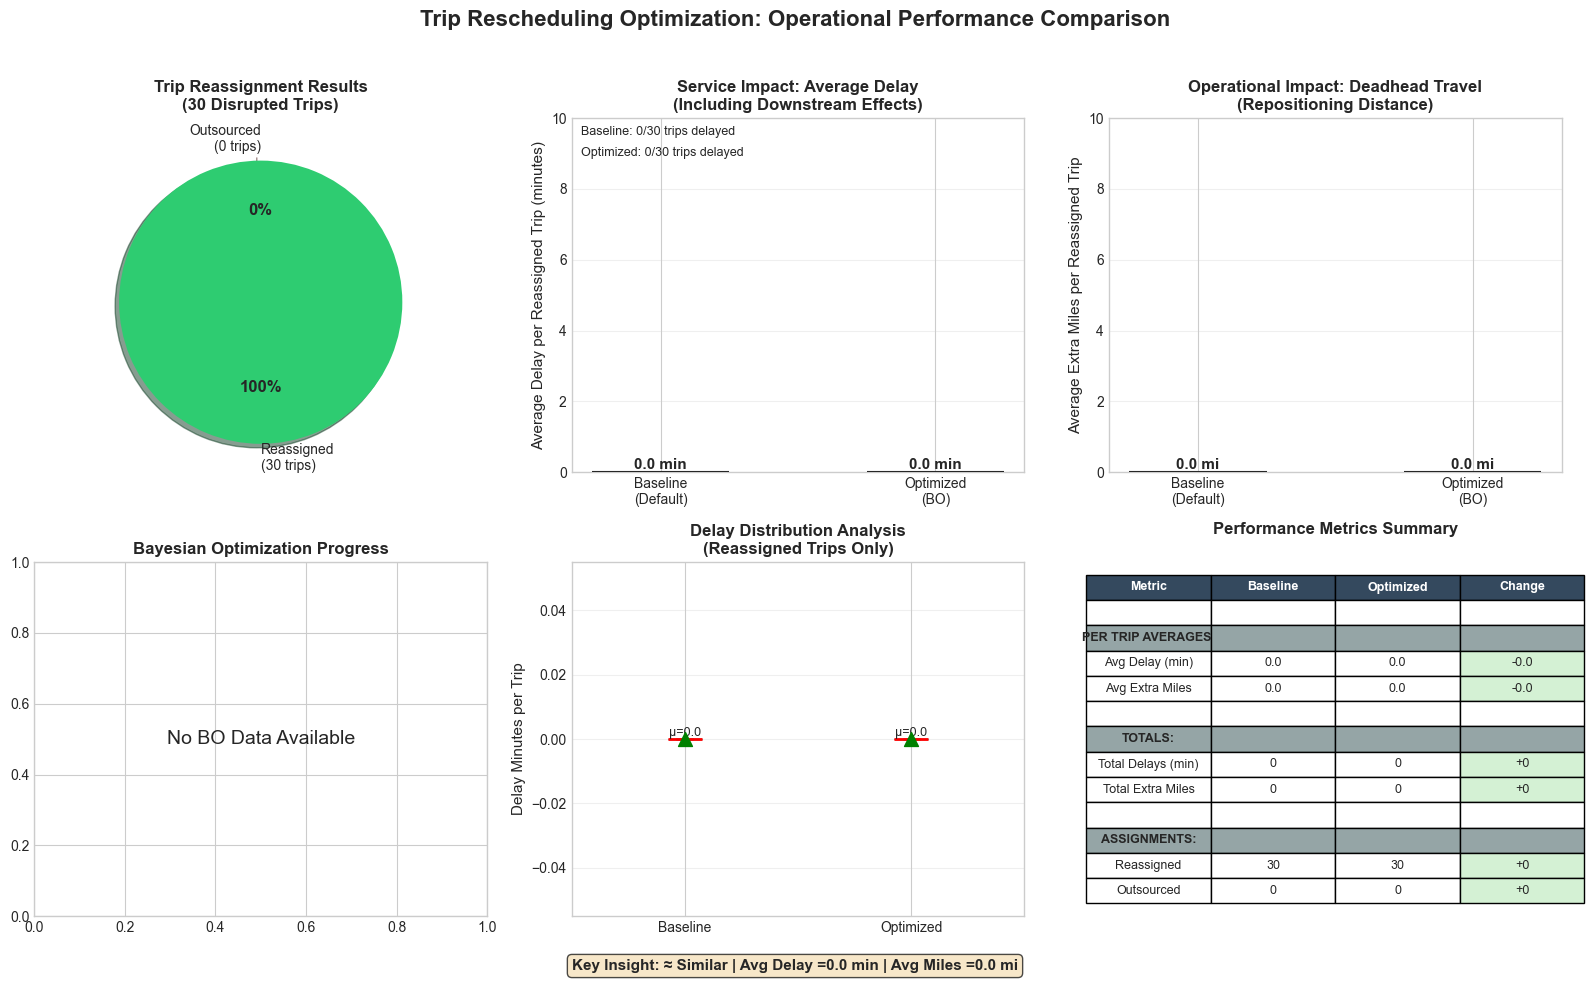

✅ Dashboard created successfully

📋 Creating detailed metrics comparison...

📊 DETAILED PERFORMANCE METRICS COMPARISON:
                                 Metric Baseline Optimized (BO)
                  Total Disrupted Trips       30             30
                Successfully Reassigned       30             30
                             Outsourced        0              0
Average Delay per Reassigned Trip (min)      0.0            0.0
Average Extra Miles per Reassigned Trip      0.0            0.0
                    Total Delay Minutes        0              0
                      Total Extra Miles        0              0
                  Trips with Zero Delay       30             30
                      Trips with Delays        0              0
             Maximum Single Delay (min)        0              0

🎯 KEY PERFORMANCE IMPROVEMENTS:
--------------------------------------------------
Average Delay per Trip:     +0.0 minutes
Average Extra Miles per Trip: +0.0 miles
Total Dela

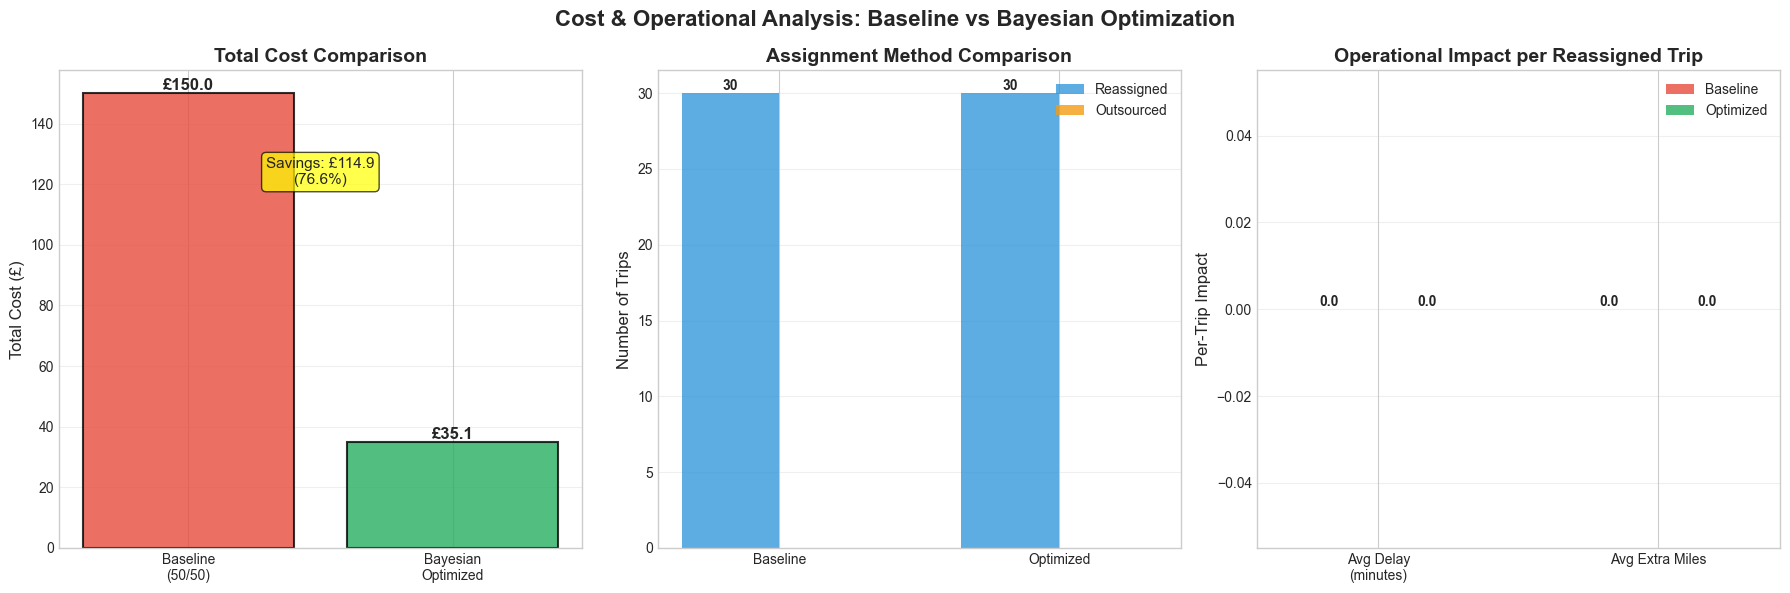

✅ Cost breakdown visualization created

📈 Creating optimization progress visualization...


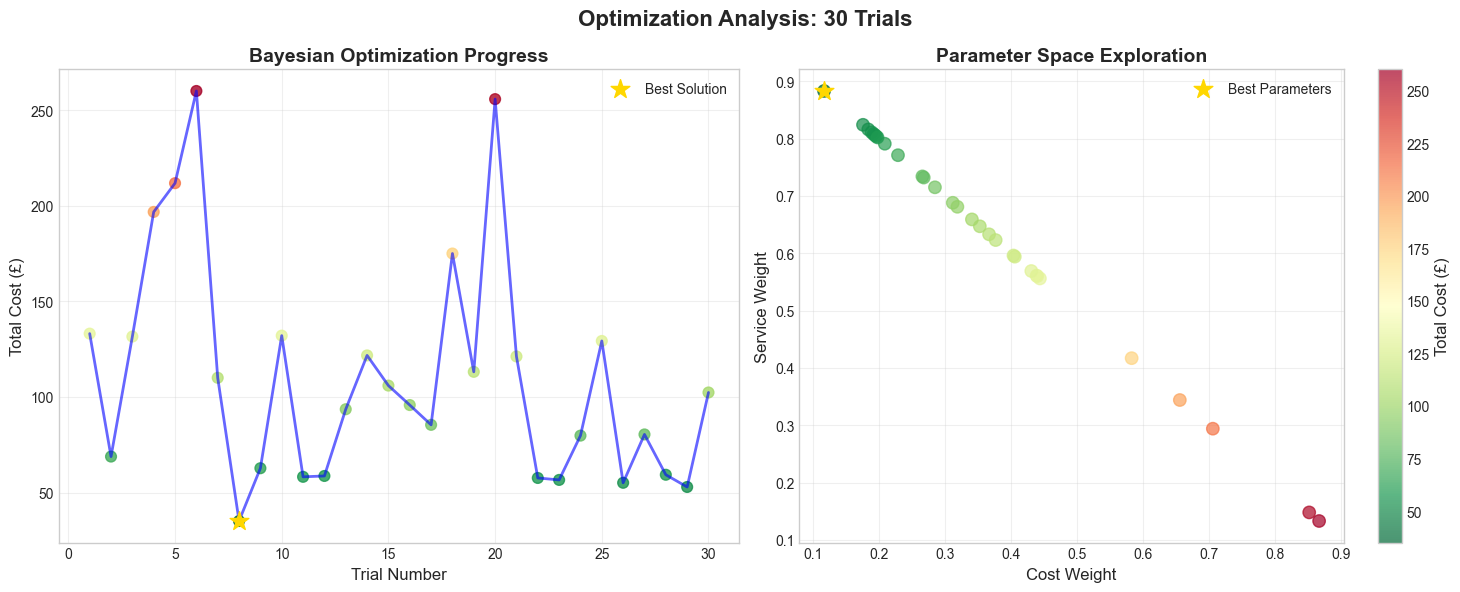

✅ Optimization progress visualization created

🎉 All visualizations completed!


In [16]:
# %%
# ============================================================================
# PERFORMANCE VISUALIZATION - COMPREHENSIVE COMPARISON
# ============================================================================

print("\n📊 GENERATING PERFORMANCE COMPARISON VISUALIZATIONS")
print("=" * 60)

# Import visualization utilities
import sys
sys.path.append('..')
from src.utils.visualization_helper import MetricsVisualizer

# Ensure we have solutions to compare
if 'baseline_solution' not in locals() or 'optimized_solution' not in locals():
    print("❌ Missing solution data - run optimization cells first")
else:
    print("✅ Solution data found - creating visualizations...")
    
    # %%
    # ============================================================================
    # 1. COMPREHENSIVE COMPARISON DASHBOARD
    # ============================================================================
    
    print("\n📈 Creating comprehensive comparison dashboard...")
    
    try:
        # Create the main comparison dashboard using the visualization helper
        fig = MetricsVisualizer.create_comparison_dashboard(
            baseline_solution=baseline_solution,
            bo_solution=optimized_solution, 
            disrupted_trips=disrupted_trips,
            bo_tuner=optimizer if 'optimizer' in locals() else None
        )
        
        # Display the dashboard
        plt.show()
        
        print("✅ Dashboard created successfully")
        
    except Exception as e:
        print(f"❌ Error creating dashboard: {str(e)}")
        print("📊 Creating simplified comparison instead...")
    
    # %%
    # ============================================================================
    # 2. DETAILED METRICS COMPARISON TABLE
    # ============================================================================
    
    print("\n📋 Creating detailed metrics comparison...")
    
    try:
        # Generate detailed comparison summary
        comparison_df = MetricsVisualizer.create_simple_summary(
            baseline_solution=baseline_solution,
            bo_solution=optimized_solution,
            disrupted_trips=disrupted_trips
        )
        
        print("\n📊 DETAILED PERFORMANCE METRICS COMPARISON:")
        print("=" * 80)
        print(comparison_df.to_string(index=False))
        
        # Calculate key improvements
        baseline_metrics = MetricsVisualizer.extract_operational_metrics(baseline_solution)
        optimized_metrics = MetricsVisualizer.extract_operational_metrics(optimized_solution)
        
        delay_improvement = baseline_metrics['avg_delay_per_reassigned'] - optimized_metrics['avg_delay_per_reassigned']
        miles_improvement = baseline_metrics['avg_miles_per_reassigned'] - optimized_metrics['avg_miles_per_reassigned']
        
        print("\n🎯 KEY PERFORMANCE IMPROVEMENTS:")
        print("-" * 50)
        print(f"Average Delay per Trip:     {delay_improvement:+.1f} minutes")
        print(f"Average Extra Miles per Trip: {miles_improvement:+.1f} miles")
        print(f"Total Delay Reduction:      {baseline_metrics['total_delay_minutes'] - optimized_metrics['total_delay_minutes']:+.0f} minutes")
        print(f"Total Miles Reduction:      {baseline_metrics['total_deadhead_miles'] - optimized_metrics['total_deadhead_miles']:+.0f} miles")
        
        # Performance verdict
        if delay_improvement > 0 and miles_improvement > 0:
            verdict = "🏆 WIN-WIN: Better service AND lower operational costs"
        elif delay_improvement > 0 or miles_improvement > 0:
            verdict = "⚖️ TRADE-OFF: Improvement in one area, compromise in another"
        else:
            verdict = "≈ SIMILAR: Minimal difference between approaches"
        
        print(f"\n{verdict}")
        
    except Exception as e:
        print(f"❌ Error creating detailed comparison: {str(e)}")
    
    # %%
    # ============================================================================
    # 3. COST BREAKDOWN VISUALIZATION
    # ============================================================================
    
    print("\n💰 Creating cost breakdown visualization...")
    
    try:
        # Create cost comparison charts
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Extract cost data
        baseline_cost = baseline_solution.objective_value / 1000
        optimized_cost = optimized_solution.objective_value / 1000
        cost_savings = baseline_cost - optimized_cost
        
        # 1. Total Cost Comparison (Bar Chart)
        methods = ['Baseline\n(50/50)', f'{OPTIMIZATION_CONFIG["method"].title()}\nOptimized']
        costs = [baseline_cost, optimized_cost]
        colors = ['#e74c3c', '#27ae60']
        
        bars = ax1.bar(methods, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bar, cost in zip(bars, costs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'£{cost:.1f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12)
        
        ax1.set_ylabel('Total Cost (£)', fontsize=12)
        ax1.set_title('Total Cost Comparison', fontweight='bold', fontsize=14)
        ax1.grid(axis='y', alpha=0.3)
        
        # Add savings annotation
        if cost_savings != 0:
            savings_pct = (cost_savings / baseline_cost) * 100
            ax1.text(0.5, max(costs) * 0.8, 
                    f'{"Savings" if cost_savings > 0 else "Extra Cost"}: £{abs(cost_savings):.1f}\n({abs(savings_pct):.1f}%)',
                    ha='center', fontsize=11, 
                    bbox=dict(boxstyle='round', facecolor='yellow' if cost_savings > 0 else 'lightcoral', alpha=0.7))
        
        # 2. Assignment Method Breakdown
        baseline_reassigned = baseline_metrics['reassigned_count']
        baseline_outsourced = baseline_metrics['outsourced_count']
        optimized_reassigned = optimized_metrics['reassigned_count']  
        optimized_outsourced = optimized_metrics['outsourced_count']
        
        x = np.arange(2)
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, [baseline_reassigned, optimized_reassigned], 
                       width, label='Reassigned', color='#3498db', alpha=0.8)
        bars2 = ax2.bar(x + width/2, [baseline_outsourced, optimized_outsourced], 
                       width, label='Outsourced', color='#f39c12', alpha=0.8)
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        ax2.set_ylabel('Number of Trips', fontsize=12)
        ax2.set_title('Assignment Method Comparison', fontweight='bold', fontsize=14)
        ax2.set_xticks(x)
        ax2.set_xticklabels(['Baseline', 'Optimized'])
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Operational Impact (Delay vs Miles)
        categories = ['Avg Delay\n(minutes)', 'Avg Extra Miles']
        baseline_ops = [baseline_metrics['avg_delay_per_reassigned'], baseline_metrics['avg_miles_per_reassigned']]
        optimized_ops = [optimized_metrics['avg_delay_per_reassigned'], optimized_metrics['avg_miles_per_reassigned']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax3.bar(x - width/2, baseline_ops, width, label='Baseline', color='#e74c3c', alpha=0.8)
        bars2 = ax3.bar(x + width/2, optimized_ops, width, label='Optimized', color='#27ae60', alpha=0.8)
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
        
        ax3.set_ylabel('Per-Trip Impact', fontsize=12)
        ax3.set_title('Operational Impact per Reassigned Trip', fontweight='bold', fontsize=14)
        ax3.set_xticks(x)
        ax3.set_xticklabels(categories)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        plt.suptitle(f'Cost & Operational Analysis: Baseline vs {OPTIMIZATION_CONFIG["method"].title()} Optimization', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("✅ Cost breakdown visualization created")
        
    except Exception as e:
        print(f"❌ Error creating cost breakdown: {str(e)}")
    
    # %%
    # ============================================================================
    # 4. OPTIMIZATION PROGRESS (if available)
    # ============================================================================
    
    if 'optimizer' in locals() and hasattr(optimizer, 'trial_data') and len(optimizer.trial_data) > 3:
        print("\n📈 Creating optimization progress visualization...")
        
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Extract trial data
            trials_df = pd.DataFrame(optimizer.trial_data)
            
            # Convert objective values to costs
            objectives = [float(row['Total Cost'].replace('£', '')) for row in optimizer.trial_data]
            trials = list(range(1, len(objectives) + 1))
            
            # 1. Optimization Progress
            ax1.plot(trials, objectives, 'b-', alpha=0.6, linewidth=2)
            ax1.scatter(trials, objectives, c=objectives, cmap='RdYlGn_r', s=60, alpha=0.8)
            
            # Mark best trial
            best_idx = objectives.index(min(objectives))
            ax1.scatter(trials[best_idx], objectives[best_idx], 
                       color='gold', s=200, marker='*', label='Best Solution', zorder=5)
            
            ax1.set_xlabel('Trial Number', fontsize=12)
            ax1.set_ylabel('Total Cost (£)', fontsize=12) 
            ax1.set_title(f'{OPTIMIZATION_CONFIG["method"].title()} Optimization Progress', 
                         fontweight='bold', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # 2. Parameter Space Exploration (Cost vs Service weights)
            if 'Cost Weight' in trials_df.columns:
                cost_weights = [float(w) for w in trials_df['Cost Weight']]
                service_weights = [float(w) for w in trials_df['Service Weight']]
                
                scatter = ax2.scatter(cost_weights, service_weights, c=objectives, 
                                   cmap='RdYlGn_r', s=80, alpha=0.7)
                
                # Mark best point
                ax2.scatter(cost_weights[best_idx], service_weights[best_idx], 
                           color='gold', s=200, marker='*', label='Best Parameters', zorder=5)
                
                ax2.set_xlabel('Cost Weight', fontsize=12)
                ax2.set_ylabel('Service Weight', fontsize=12) 
                ax2.set_title('Parameter Space Exploration', fontweight='bold', fontsize=14)
                ax2.grid(True, alpha=0.3)
                ax2.legend()
                
                # Add colorbar
                cbar = plt.colorbar(scatter, ax=ax2)
                cbar.set_label('Total Cost (£)', fontsize=12)
            
            plt.suptitle(f'Optimization Analysis: {len(optimizer.trial_data)} Trials', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("✅ Optimization progress visualization created")
            
        except Exception as e:
            print(f"❌ Error creating optimization progress: {str(e)}")
    
    print("\n🎉 All visualizations completed!")
    print("=" * 60)